In [1]:
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import boston_housing

2021-07-30 02:33:39.608613: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-30 02:33:39.608638: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
mean = train_data.mean()
train_data -= mean
test_data -= mean
std = train_data.std()
train_data /= std
test_data /= std

In [4]:
def build_network() -> models.Sequential:
    network = models.Sequential(
        [
            layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)),
            layers.Dense(64, activation='relu'),
            layers.Dense(1),
        ]
    )
    network.compile(optimizer='rmsprop', loss='mse', metrics=['mae', ])

    return network

In [5]:
k_fold_len = 4
num_val_samples = len(train_data) // k_fold_len
num_epochs = 100
all_scores = list()
all_mae_histories = list()

for i in range(k_fold_len):
    print(f'fold №{i + 1}')
    l, r = i * num_val_samples, (i + 1) * num_val_samples
    val_data = train_data[l:r]
    val_targets = train_targets[l:r]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0
    )
    network = build_network()
    history = network.fit(partial_train_data,
                          partial_train_targets,
                          epochs=num_epochs,
                          batch_size=1, )
    # print(history.history.keys())
    mae_history = history.history['mae']
    all_mae_histories.append(mae_history)
    val_mse, val_mae = network.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

fold №1


2021-07-30 02:33:40.453814: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-30 02:33:40.453836: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-30 02:33:40.453853: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (toliman): /proc/driver/nvidia/version does not exist
2021-07-30 02:33:40.453997: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-30 02:33:40.669188: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimi

Epoch 1/100
303/303 [==============================] - 0s 427us/step - loss: 139.6279 - mae: 8.6425
Epoch 2/100
303/303 [==============================] - 0s 392us/step - loss: 65.8650 - mae: 5.6618
Epoch 3/100
303/303 [==============================] - 0s 439us/step - loss: 62.1084 - mae: 5.4366

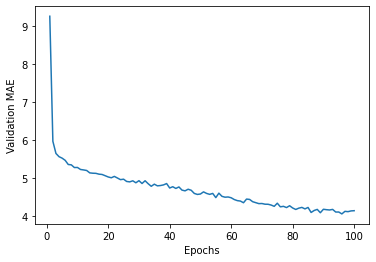

[4.939255714416504, 5.645605087280273, 5.593626499176025, 4.942589282989502]


In [6]:
import matplotlib.pyplot as plt

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

print(all_scores)
